In [59]:
import os, shutil
from os.path import join as joinpath
from os import listdir
import json

In [60]:
"""
# Expected input format: an `images` folder with all images in flat structure, i.e. as direct children.
datadir = "/mnt/beegfs/home/vu/Codalab-MetaDL/data/resisc45/resisc45-resized-formatted-new"
imagedir = joinpath(datadir, "images")
resultdir = "/mnt/beegfs/home/vu/Codalab-MetaDL/result"

# path to metadata file with at least 2 columns: filename and label
# metadata_filepath = joinpath(datadir, "resisc45-filtered-metadata.csv")
metadata_filepath = joinpath(datadir, "labels.csv")

# names of these 2 columns
labelcolumn = "category"
filecolumn = "newfilename"

# result are saved in this folder inside the resultdir
dataname = "mini_resisc"
# prefix for output file
resultprefix = "mini_resisc-finetune"

random_seed = 2021
"""

'\n# Expected input format: an `images` folder with all images in flat structure, i.e. as direct children.\ndatadir = "/mnt/beegfs/home/vu/Codalab-MetaDL/data/resisc45/resisc45-resized-formatted-new"\nimagedir = joinpath(datadir, "images")\nresultdir = "/mnt/beegfs/home/vu/Codalab-MetaDL/result"\n\n# path to metadata file with at least 2 columns: filename and label\n# metadata_filepath = joinpath(datadir, "resisc45-filtered-metadata.csv")\nmetadata_filepath = joinpath(datadir, "labels.csv")\n\n# names of these 2 columns\nlabelcolumn = "category"\nfilecolumn = "newfilename"\n\n# result are saved in this folder inside the resultdir\ndataname = "mini_resisc"\n# prefix for output file\nresultprefix = "mini_resisc-finetune"\n\nrandom_seed = 2021\n'

In [61]:
# Expected input format: an `images` folder with all images in flat structure, i.e. as direct children.
# datadir = "/mnt/beegfs/home/vu/Codalab-MetaDL/src/meta-album/meta-album-main/data/omniprint2"
datadir = "/mnt/beegfs/home/vu/Codalab-MetaDL/data/alldata/formatted-image/plants"

imagedir = joinpath(datadir, "images")
resultdir = "/mnt/beegfs/home/vu/Codalab-MetaDL/result"

# path to metadata file with at least 2 columns: filename and label
# metadata_filepath = joinpath(datadir, "resisc45-filtered-metadata.csv")
metadata_filepath = joinpath(datadir, "labels.csv")

# names of these 2 columns
# labelcolumn = "CATEGORY"
# filecolumn = "FILE_NAME"

# result are saved in this folder inside the resultdir
dataname = "mini_plantvillage"
# prefix for output file
resultprefix = "fewshot_baseline"

random_seed = 2021
print(f"{random_seed = }")

random_seed = 2021


In [62]:
setting_numberway = 5
setting_numbershot = 5
setting_iteration = 3

In [63]:
info_filepath = joinpath(datadir, "info.json")

# if os.path.exists(info_filepath):
with open(info_filepath) as file:
    infofile = json.load(file)

labelcolumn = infofile['category_column_name']
filecolumn = infofile['image_column_name']             
# else:
#     labelcolumn = "CATEGORY"
#     filecolumn = "FILE_NAME"

In [64]:
outputdir = joinpath(resultdir, resultprefix, dataname)
os.makedirs(outputdir, exist_ok=True)
# figdir = joinpath(resultdir, dataname, resultprefix, 'fig')
# modeldir = joinpath(resultdir, dataname, resultprefix, 'model')
# metricdir = joinpath(resultdir, dataname, resultprefix, 'metric')

# for outputdir in (figdir, modeldir, metricdir):
#     os.makedirs(outputdir, exist_ok=True)

In [65]:
# import os, shutil
# from os.path import join as joinpath

from pathlib import Path

import sys, copy
import itertools, math

from functools import partial
import json

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# from tqdm import tqdm_notebook as tqdm
# from tqdm.autonotebook import tqdm
# from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics

import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.autograd as autograd

import captum.attr
import scipy

In [66]:
def set_random_seed(random_seed):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)
        
set_random_seed(random_seed)

In [67]:
# libpath = "/mnt/beegfs/home/vu/Codalab-MetaDL/lib"
# if libpath not in sys.path: 
#     sys.path.append(libpath)
    
# import dropblock

In [148]:
pd.options.mode.chained_assignment = None 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# cpu has better error message for debugging
# device = torch.device("cpu")

pltparams = {
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
    'figure.titlesize': 'x-large',
    'savefig.dpi': 300,
}
plt.rcParams.update(pltparams)

sns.set(font_scale = 1.2)

## Preprocess and explore data

In [69]:
filtered_metadata = pd.read_csv(metadata_filepath, index_col=0)
# filtered_metadata = pd.read_csv(metadata_filepath)
filtered_frequency = filtered_metadata.value_counts(labelcolumn)
filtered_metadata.sample(5)

,file,category,supercategory,size_byte,size_kb,newfilename,has_supercategory
39703,Strawberry-healthy/image (198).JPG,Strawberry-healthy,Strawberry,17377,16,39703.jpg,0
43901,Apple-Cedar_apple_rust/image (25).JPG,Apple-Cedar_apple_rust,Apple,10278,10,43901.jpg,0
38630,Orange-Haunglongbing_(Citrus_greening)/image (...,Orange-Haunglongbing_(Citrus_greening),Orange,12631,12,38630.jpg,0
31054,Grape-Leaf_blight_(Isariopsis_Leaf_Spot)/image...,Grape-Leaf_blight_(Isariopsis_Leaf_Spot),Grape,17171,16,31054.jpg,0
7681,Strawberry-Leaf_scorch/image (364).JPG,Strawberry-Leaf_scorch,Strawberry,19948,19,7681.jpg,0


Text(0.5, 0.98, 'mini_plantvillage')

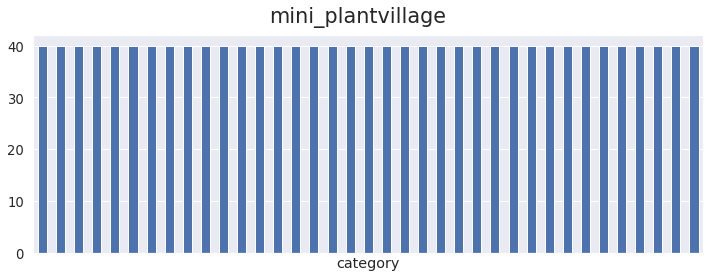

In [70]:
plt.figure(figsize=(12, 4))
# ax = frequency[frequency >= 20].plot(kind="bar")
ax = filtered_frequency.plot(kind="bar")
ax.set_xticks([])
plt.suptitle(dataname)
# ax.figure.savefig(joinpath(figdir, f'{dataname}-distribution.png'), bbox_inches='tight')

In [71]:
# class_weights = filtered_frequency.max()/filtered_frequency
# class_weights

## Load data

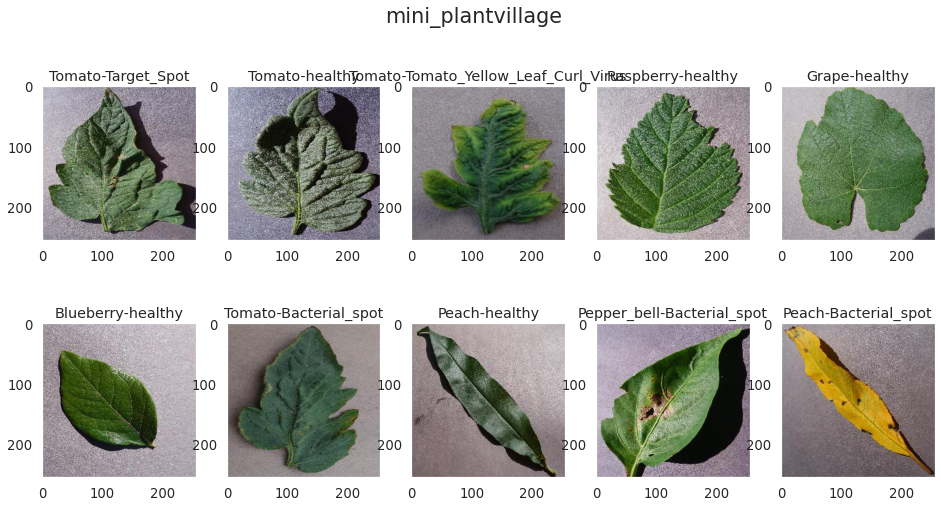

In [72]:
def tensor_to_display(imagetensor):
    return imagetensor.numpy().transpose((1, 2, 0))

def show_images(metadata, imagedir, rows=2, columns=5, figsize=(16, 8), title=None):
    sns.set_style("dark")

    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    axes = axes.flatten()
    
    for index, ax in enumerate(axes):
        imageinfo = metadata.iloc[index]
        image = PIL.Image.open(joinpath(imagedir, imageinfo[filecolumn]))
        width, height = image.size
#         print(width,height)
        ax.imshow(image)
        ax.set_title(imageinfo[labelcolumn])
#         plt.axis('off')

    if title is not None:
        plt.suptitle(title)
    
    return fig

fig = show_images(filtered_metadata.sample(10), imagedir, title=dataname)

# fig.savefig(joinpath(basedir, 'fig', f'{dataname}-sample-image.png'))


In [73]:
def encode_label(metadata):
    labelcode = LabelEncoder()
    metadata.loc[:,"labelcode"] = labelcode.fit_transform(metadata[labelcolumn])
    return metadata, labelcode

In [74]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, metadata, imagedir, transform=None):
        self.metadata = metadata
        self.imagedir = imagedir
        self.transform = transform
    
    def __getitem__(self, index):
        imageinfo = self.metadata.iloc[index]
        
        imagedata = PIL.Image.open(os.path.join(self.imagedir, imageinfo[filecolumn])) 
        transformed_image = self.transform(imagedata) if self.transform else imagedata
        label = imageinfo["labelcode"]
#         print(transformed_image.shape)

        return transformed_image, label

    def __len__(self):
        return len(self.metadata)
    

def get_dataloader(dataset, batchsize, ifshuffle):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=ifshuffle)
    return dataloader


In [75]:
# # filtered_metadata = filter_metadata(metadata, frequency)
# processed_metadata, labelcode = encode_label(filtered_metadata)
# train_metadata, valid_metadata = train_test_split(processed_metadata, test_size=0.5, stratify=processed_metadata[labelcolumn], random_state=2021)
# # train_metadata, valid_metadata = train_test_split(processed_metadata, train_size=1/8, stratify=processed_metadata[labelcolumn], random_state=2021)
# print(train_metadata.shape, valid_metadata.shape)

# numberclass = valid_metadata["labelcode"].max() + 1
# labelnames = labelcode.inverse_transform(range(numberclass))
# print(numberclass)

In [76]:
def save_train_test_split(train_metadata, test_metadata, output_path):
    train_metadata['partition'] = 'train'
    valid_metadata['partition'] = 'test'
    
    all_metadata = pd.concat([train_metadata, valid_metadata]).drop(columns='labelcode')
    all_metadata.to_csv(output_path, index=False)
    print(all_metadata.sample(5))
    
    return output_path

# save_train_test_split(train_metadata, valid_metadata, joinpath(datadir, 'sd128_v1_crop_test025.csv'))

In [77]:
def train_transform(pil_image, imagesize):
    width, height = pil_image.size
    transform = transforms.Compose([
        transforms.CenterCrop(min(width, height)),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.Resize(imagesize),
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(pil_image)

def test_transform(pil_image, imagesize):
    transform = transforms.Compose([
        transforms.Resize(imagesize),
        transforms.ToTensor(),
    ])
    return transform(pil_image)


def build_data(train_metadata, valid_metadata, imagedir, train_transform, test_transform, batchsize=128):
#     imagesize = (128, 128)
#     transform0 = partial(transform_image, imagesize=(imagesize))

    train_dataset = ImageDataset(train_metadata, imagedir, train_transform)
    train_dataloader = get_dataloader(train_dataset, batchsize=batchsize, ifshuffle=True)

    valid_dataset = ImageDataset(valid_metadata, imagedir, test_transform)
    valid_dataloader = get_dataloader(valid_dataset, batchsize=batchsize, ifshuffle=False)

    return train_dataset, valid_dataset, train_dataloader, valid_dataloader


In [78]:
def display_tensor(dataloader, labelcode):
    inputs, labels = next(iter(dataloader))
    print(inputs.shape, labels.shape)
    for inpt, label in zip(inputs[:4], labels[:4]):
        plt.figure()
        plt.imshow(tensor_to_display(inpt))
        plt.title(labelcode.inverse_transform([label]))


In [99]:
def generate_episode(metadata, nway, kshot, imagedir, train_transform, test_transform, randomseed):
    alllabels = metadata[labelcolumn].unique()
    np.random.seed(randomseed)
    permutedlabels = np.random.permutation(alllabels)
    maxindex = len(alllabels) - len(alllabels) % nway
    episodelabels = np.split(permutedlabels[:maxindex], np.arange(nway, maxindex, nway))
#     episodelabels = np.array_split(permutedlabels[:maxindex], nway)
    
    for current_episodelabels in episodelabels:
#         print(current_episodelabels)
        episode_metadata = metadata[metadata[labelcolumn].isin(current_episodelabels)]
        
        processed_metadata, labelcode = encode_label(episode_metadata)
        train_metadata, valid_metadata = train_test_split(processed_metadata, train_size=kshot/40, 
            stratify=processed_metadata[labelcolumn], random_state=randomseed)
#         print(f"{train_metadata.shape=} {valid_metadata.shape=}")
#         print(np.intersect1d(train_metadata[filecolumn], valid_metadata[filecolumn]))
#         print(train_metadata)

        train_dataset, valid_dataset, train_dataloader, valid_dataloader = build_data(
            train_metadata, valid_metadata, imagedir, train_transform, test_transform)
        
        yield train_dataset, valid_dataset, train_dataloader, valid_dataloader, labelcode

        

In [100]:
imagesize = (128, 128)
train_transform0 = partial(train_transform, imagesize=(imagesize))
test_transform0 = partial(test_transform, imagesize=imagesize)

train_dataset, valid_dataset, train_dataloader, valid_dataloader, labelcode = next(iter(
    generate_episode(filtered_metadata, setting_numberway, setting_numbershot, imagedir, 
    train_transform0, test_transform0, randomseed=random_seed)))

torch.Size([25, 3, 128, 128]) torch.Size([25])


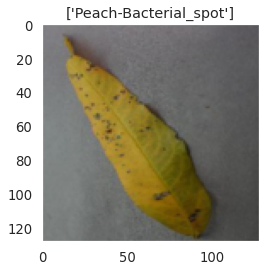

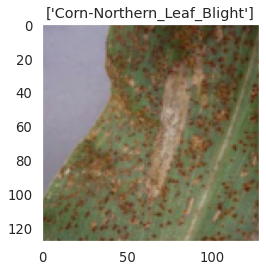

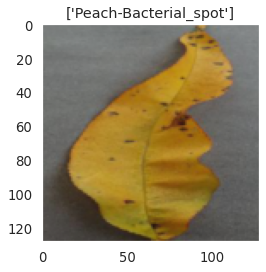

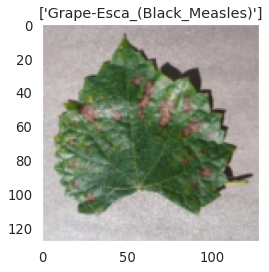

In [101]:
inputs, labels = next(iter(train_dataloader))
print(inputs.shape, labels.shape)
for inpt, label in zip(inputs[:4], labels[:4]):
    plt.figure()
    plt.imshow(tensor_to_display(inpt))
    plt.title(labelcode.inverse_transform([label]))

## Define training

In [102]:
def onebatch(model, inputs, labels, lossfunc, device):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = lossfunc(outputs, labels)
    
    predictions = torch.argmax(outputs, dim=1)  
#     correct_count = (predictions == labels).sum()

    return loss, predictions, labels

def score_predictions(predictions, targets):
    score = sklearn.metrics.balanced_accuracy_score(targets, predictions)
    return score

scorename = 'balanced_accuracy'

In [103]:
def allbatch(model, dataloader, lossfunc, device, ifbackward, optim=None, batch_lr_scheduler=None):
    sum_loss = 0; predictions = []; targets = []
    losses = []
    sample_count = 0

    for inputs, labels in dataloader:
        if ifbackward: optim.zero_grad()
            
        batch_loss, batch_prediction, batch_target = onebatch(model, inputs, labels, lossfunc, device)
#         sum_loss += batch_loss.item()
        losses.append(batch_loss)
        sample_count += len(labels)
    
        predictions.append(batch_prediction)
        targets.append(batch_target)
            
        if ifbackward:
            batch_loss.backward()
            optim.step()
            
        if batch_lr_scheduler: batch_lr_scheduler.step()
    
    predictions = torch.cat(predictions).cpu().detach()
    targets = torch.cat(targets).cpu().detach()
    losses = torch.Tensor(losses)
    score = score_predictions(predictions, targets)
    
    return losses.sum().item()/sample_count, score

In [104]:
def build_result(validscore, validloss, trainscore, trainloss, epoch):
    result = dict(validscore=validscore, validloss=validloss, 
                  trainscore=trainscore, trainloss=trainloss, epoch=epoch)
    return result

def update_best_result(bestresult, currentresult):
    if currentresult['validscore'] > bestresult['validscore']:
        for key in "validscore validloss trainscore trainloss epoch".split(" "):
            command = f"""bestresult['{key}'] = currentresult['{key}']"""
#             print(command)
            exec(command)
        
    return  bestresult


In [105]:
metricnames = "trainloss trainscore validloss validscore".split(' ')

# def init_metric(metricnames):
#     metric = {metricname:[] for metricname in metricnames}
#     return metric

# def update_metric(metric, updatedict):
#     for metricname, metricvalue in updatedict.items():
#         metric[metricname].append(metricvalue)
    
#     return metric
    
def update_metric(metricnames, labelcode, epoch, metric, updatedict):
    if not metric:
        metric = {f"label{i+1}": label for i, label in enumerate(labelcode.classes_)}
    
    for metricname, metricvalue in updatedict.items():
        metric[f"{metricname}{epoch}"] = metricvalue
            
    return metric 
    
def record_best_result(metricnames, bestresult, metric):
    for metricname in metricnames:
        metric[f"best_{metricname}"] = bestresult[metricname]
    return metric

In [106]:
def train(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, 
          labelcode, resultpath, optim, lossfunc, device, metricnames, 
          epoch_lr_scheduler=None, batch_lr_scheduler=None,
          epochs=5):

    
#     for epoch in tqdm(range(epochs)):
    best_result = build_result(0, 0, 0, 0, 0)
    metric={}
    
    for epoch in range(1, epochs+1):
        model.train()

        train_epoch_loss, train_epoch_score = allbatch(model, train_dataloader, lossfunc, device, 
            ifbackward=True, optim=optim, batch_lr_scheduler=batch_lr_scheduler)
        metric = update_metric(metricnames, labelcode, epoch,
                               metric, dict(trainloss=train_epoch_loss, trainscore=train_epoch_score))
    
        
        model.eval()
        with torch.no_grad():
            valid_epoch_loss, valid_epoch_score = allbatch(model, valid_dataloader, lossfunc, device, 
                ifbackward=False, optim=None)
        
        metric = update_metric(metricnames, labelcode, epoch,
                               metric, dict(validloss=valid_epoch_loss, validscore=valid_epoch_score))        
        
        current_result = build_result(valid_epoch_score, valid_epoch_loss, 
                                      train_epoch_score, train_epoch_loss, epoch)
        best_result = update_best_result(best_result, current_result)
        
#         if (epochs <= 10) or (epoch % (epochs//10) == 0):
#             print(f"\nEpoch {epoch} / {epochs}")
#             print(f" train loss = {train_epoch_loss} ; train score = {train_epoch_score}")
#             print(f" valid loss = {valid_epoch_loss} ; valid score = {valid_epoch_score}")
            
        if epoch_lr_scheduler:
            epoch_lr_scheduler.step(valid_epoch_loss)
#             print('Epoch: ', epoch,' LR:', epoch_lr_scheduler.get_last_lr())

    # end epoch loop
    record_best_result(metricnames, best_result, metric)
#     print("\nLabels: ", labelcode.classes_)
#     print("Best valid result: ", best_result)
    return best_result, metric
        

In [107]:
def record_metric(metric, resultpath):
    metricdf = pd.DataFrame(metric)
    with open(resultpath, 'a') as file:
        metricdf.to_csv(file, header=file.tell()==0, index=False)
    return metricdf


## Model

In [108]:
# def save_model(model, modelpath):
#     parent, filename = os.path.split(modelpath)
#     if parent: os.makedirs(parent, exist_ok=True)
#     torch.save(model, modelpath)
    
# def save_result(result, resultpath):
#     parent, filename = os.path.split(resultpath)
#     if parent: os.makedirs(parent, exist_ok=True)
#     with open(resultpath, "w") as file:
#         json.dump(result, file)    

# def load_model(modelpath):
#     model = torch.load(modelpath)
#     return model

# def save_checkpoint(model, optimizer, loss, savepath, epoch):
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, savepath)
#     return savepath

# def load_checkpoint(filepath, model, optimizer):
#     checkpoint = torch.load(filepath)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
    
#     return model, optimizer, epoch, loss
    

In [109]:
def get_optim_param_dict(model, lrrange):
    paramgroups = {}
    namegroup = {}
    
    for name, param in model.named_parameters():
        groupname = '.'.join(name.split('.')[:3])
        
#         layergroup = namegroup.setdefault(groupname, [])
#         layergroup.append(name)
#         namegroup[groupname] = layergroup
    
        paramgroup = paramgroups.setdefault(groupname, [])
        paramgroup.append(param)
        paramgroups[groupname] = paramgroup
    
    lrgroup = np.geomspace(*lrrange, num=len(paramgroups))
#     optim_param = [dict(params=group, lr=lr, weight_decay=1e-3) for group, lr in zip(paramgroups.values(), lrgroup)]
    print(namegroup)
    return optim_param

def get_optim_param_dict_resnet(model, lrrange, weightdecay):
    paramgroups = {}
    namegroup = {}
    
    for name, param in model.named_parameters():
#         print(name)
        groupname = '.'.join(name.split('.')[:2])
        
        if groupname.startswith("fc"):
            groupname = "fc"
        
        layergroup = namegroup.setdefault(groupname, [])
        layergroup.append(name)
        namegroup[groupname] = layergroup
    
        paramgroup = paramgroups.setdefault(groupname, [])
        paramgroup.append(param)
        paramgroups[groupname] = paramgroup
    
    lrgroup = np.geomspace(*lrrange, num=len(paramgroups))
#     optim_param = [dict(params=group, lr=lr, weight_decay=0.1) for group, lr in zip(paramgroups.values(), lrgroup)]
    optim_param = [dict(params=group, lr=lr, weight_decay=weightdecay) for group, lr in zip(paramgroups.values(), lrgroup)]

    return optim_param
    
# optim_param = get_optim_param_dict(model, (1e-6, 1e-3))
# len(optim_param)

In [110]:
def get_optimizer(model, lr=1e-4, weightdecay=1e-3):
    optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weightdecay)
#     optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-3, momentum=0.9)
#     optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weightdecay)

    return optim

def get_lrrange_optimizer(model, lrrange, get_paramdict_func, weightdecay=1e-3):
#     optim = torch.optim.Adam(get_optim_param_dict(model, lrrange), lr=lrrange[-1], weight_decay=1e-3)
#     optim = torch.optim.Adam(get_paramdict_func(model, lrrange), lr=lrrange[-1])
#     optim = torch.optim.SGD(get_paramdict_func(model, lrrange), lr=lrrange[-1], weight_decay=0.1, momentum=0)
    optim = torch.optim.SGD(get_paramdict_func(model, lrrange, weightdecay), lr=lrrange[-1])

    return optim

def get_epoch_lr_scheduler(optimizer, epochs=None):
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#     milestones = [int(epochs*fraction) for fraction in (3/4, 7/8)]
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1, verbose=False)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, verbose=False)
    return scheduler

def get_batch_lr_scheduler(optimizer, dataloader, epochs):
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3,step_size_up=10,mode="triangular2")
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(dataloader), epochs=epochs)
    return scheduler

## Run training

In [111]:
def get_model_resnet_dropblock(outsize):
    model = models.resnet18(pretrained=True)
  
    drop_proba = dict(layer4=0.1, layer3=0.1)
    for layer, sublayer, module in itertools.product(drop_proba.keys(), [0, 1], "conv1 conv2".split()):
        modulename = f"""model.{layer}[{sublayer}].{module}"""
        command = f"""{modulename} = nn.Sequential(dropblock.DropBlock2D(drop_prob={drop_proba[layer]}, block_size=3), {modulename})"""
#         print(command)
        exec(command)
    
    for layer, proba in drop_proba.items():
        command = f"""conv_outchannels = model.{layer}[0].conv2[1].out_channels"""
        exec(command)
        modulename = f"""model.{layer}[0].bn2"""
        command = f"""{modulename} = nn.Sequential(dropblock.DropBlock2D(drop_prob=proba, block_size=3), {modulename})"""
        exec(command)  
    
    conv_outsize = model.fc.in_features
    model.fc = nn.Linear(conv_outsize, outsize)
    
    return model.to(device)

In [112]:
def get_model_resnet_dropout(outsize, with_dropout=True):
    model = models.resnet18(pretrained=True)
    if with_dropout:
        drop_proba = dict(layer4=0.1, layer3=0.1)
#         drop_proba = dict(layer4=0.1)

        for layer, sublayer, module in itertools.product(drop_proba.keys(), [0,1], "conv1 conv2".split()):
            modulename = f"""model.{layer}[{sublayer}].{module}"""
            command = f"""{modulename} = nn.Sequential(nn.Dropout({drop_proba[layer]}), {modulename})"""
    #         print(command)
            exec(command)

        for layer, proba in drop_proba.items():
            command = f"""conv_outchannels = model.{layer}[0].conv2[1].out_channels"""
            exec(command)
            modulename = f"""model.{layer}[0].bn2"""
            command = f"""{modulename} = nn.Sequential(nn.Dropout(proba), {modulename})"""
            exec(command)
                
#     prefixes = "conv1 bn1 layer1 layer2 layer3 layer4.0".split()
    for name, params in model.named_parameters():
#         if any(name.startswith(prefix) for prefix in prefixes):
        params.requires_grad = False

    conv_outsize = model.fc.in_features
    model.fc = nn.Linear(conv_outsize, outsize)

    return model.to(device)

In [113]:
# models.resnet18()

In [114]:

def repeat_train(metadata, nway, kshot, imagedir, resultpath, metricnames, device, number_iteration=1):
    imagesize = (128, 128)
    train_transform0 = partial(train_transform, imagesize=(imagesize))
    test_transform0 = partial(test_transform, imagesize=imagesize)
    number_epoch = 5

    for iteration in range(1, number_iteration+1):
        iteration_metrics = []

        for episode in generate_episode(filtered_metadata, setting_numberway, setting_numbershot, imagedir, 
            train_transform0, test_transform0, randomseed=random_seed + iteration):
            
            train_dataset, valid_dataset, train_dataloader, valid_dataloader, labelcode = episode            
        
            lossfunc = nn.CrossEntropyLoss(reduction='sum')

            model = get_model_resnet_dropout(nway, with_dropout=True)

            optim = get_optimizer(model, lr=1e-3, weightdecay=10)
#             optim = get_lrrange_optimizer(model, (1e-8, 1e-3), get_optim_param_dict_resnet, weightdecay=10)
            lr_scheduler = get_epoch_lr_scheduler(optim, number_epoch)

            best_result, metric = train(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, 
                  labelcode, resultpath, optim, lossfunc, device, metricnames, 
                  epochs=number_epoch, epoch_lr_scheduler=lr_scheduler, batch_lr_scheduler=None)

#             print(metric)
            metric["iteration"] = iteration
            iteration_metrics.append(metric)
        # end episode loop
        metricdf = record_metric(iteration_metrics, resultpath)   
    #end iteration loop
    return 
        

In [115]:
resultpath = joinpath(outputdir, "allmetric.csv")
if os.path.exists(resultpath): os.remove(resultpath)
    
print("epoch5_lr1e-3_weighdecay10_dropout0101")

repeat_train(filtered_metadata, setting_numberway, setting_numbershot, 
    imagedir, resultpath, metricnames, device, number_iteration=3)

metricdf = pd.read_csv(resultpath)
metricdf

,label1,label2,label3,label4,label5,trainloss1,trainscore1,validloss1,validscore1,trainloss2,...,validscore4,trainloss5,trainscore5,validloss5,validscore5,best_trainloss,best_trainscore,best_validloss,best_validscore,iteration
0,Apple-healthy,Grape-Black_rot,Peach-Bacterial_spot,Tomato-Leaf_Mold,Tomato-Septoria_leaf_spot,1.897117,0.12,1.484161,0.360000,1.435949,...,0.502857,0.985606,0.76,1.173282,0.600000,0.985606,0.76,1.173282,0.600000,1
1,Blueberry-healthy,Grape-Leaf_blight_(Isariopsis_Leaf_Spot),Pepper_bell-Bacterial_spot,Potato-Late_blight,Raspberry-healthy,1.722244,0.20,1.985250,0.228571,1.482784,...,0.497143,0.941278,0.88,1.335319,0.497143,0.997656,0.76,1.356652,0.497143,1
2,Apple-Apple_scab,Cherry-Powdery_mildew,Corn-Cercospora_leaf_spot_(Gray_leaf_spot),Grape-healthy,Tomato-Tomato_Yellow_Leaf_Curl_Virus,1.786899,0.20,1.576199,0.308571,1.504505,...,0.354286,0.863881,0.80,1.248519,0.485714,0.863881,0.80,1.248519,0.485714,1
3,Apple-Cedar_apple_rust,Orange-Haunglongbing_(Citrus_greening),Soybean-healthy,Tomato-Late_blight,Tomato-Target_Spot,1.705992,0.16,1.631620,0.308571,1.474527,...,0.474286,0.838675,0.84,1.166569,0.577143,0.838675,0.84,1.166569,0.577143,1
4,Cherry-healthy,Strawberry-Leaf_scorch,Strawberry-healthy,Tomato-Spider_mites_(Two-spotted_spider_mite),Tomato-healthy,1.940975,0.12,1.655111,0.302857,1.560584,...,0.365714,0.902513,0.80,1.367028,0.474286,0.902513,0.80,1.367028,0.474286,1
5,Apple-Black_rot,Corn-Northern_Leaf_Blight,Grape-Esca_(Black_Measles),Potato-Early_blight,Tomato-Bacterial_spot,1.776673,0.12,1.807310,0.280000,1.421138,...,0.577143,0.881936,0.72,1.274432,0.468571,1.002408,0.60,1.219252,0.577143,1
6,Corn-healthy,Peach-healthy,Pepper_bell-healthy,Potato-healthy,Tomato-Tomato_mosaic_virus,1.860968,0.20,1.606805,0.280000,1.481421,...,0.702857,0.810299,0.80,1.178243,0.508571,1.023950,0.72,1.049653,0.702857,1
7,Blueberry-healthy,Grape-Esca_(Black_Measles),Peach-healthy,Pepper_bell-healthy,Tomato-Tomato_Yellow_Leaf_Curl_Virus,1.724858,0.28,1.630351,0.394286,1.451793,...,0.565714,0.736336,0.96,0.982522,0.645714,0.736336,0.96,0.982522,0.645714,2
8,Apple-Cedar_apple_rust,Corn-Northern_Leaf_Blight,Corn-healthy,Squash-Powdery_mildew,Tomato-Late_blight,1.944970,0.12,1.829355,0.268571,1.559745,...,0.457143,0.799834,0.84,1.331556,0.468571,0.799834,0.84,1.331556,0.468571,2
9,Apple-Black_rot,Grape-Black_rot,Grape-Leaf_blight_(Isariopsis_Leaf_Spot),Potato-Early_blight,Tomato-Tomato_mosaic_virus,1.700850,0.20,1.519299,0.314286,1.486057,...,0.691429,0.832153,0.80,1.020461,0.662857,1.083811,0.68,1.045585,0.691429,2


In [116]:
def average_metric(metricdf, savepath):
    averagedf = metricdf.groupby("iteration").mean()
    averagebest = averagedf.loc[:, averagedf.columns.str.startswith("best")]
    averagedict = averagebest.to_dict(orient="list")
#     print(averagebest)
#     iteration_average = averagebest.mean()
#     print(iteration_average)
    with open(savepath, "w") as file:
        json.dump(averagedict, file)
        
    return averagedict

average_metric_path = joinpath(outputdir, "averagemetric.json")
print(average_metric(metricdf, average_metric_path))

{'best_trainloss': [0.9449554007393974, 0.9954447501046316, 1.0043389129638671], 'best_trainscore': [0.7542857142857143, 0.7485714285714286, 0.6799999999999999], 'best_validloss': [1.2258507055165817, 1.3056371198381693, 1.3384979621731505], 'best_validscore': [0.5591836734693878, 0.5387755102040817, 0.4799999999999999]}


In [143]:

def plot_train_metric(metric, title=None):
    sns.set_theme()
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    
    axes[0].plot(metric['trainloss'], label='train_crossentropy')
    axes[0].plot(metric['validloss'], label='valid_crossentropy')
    axes[0].set_xlabel('epoch')
    axes[0].legend()

    axes[1].plot(metric['trainscore'], label='train_score')
    axes[1].plot(metric['validscore'], label='valid_score')
    axes[1].set_xlabel('epoch')
    axes[1].legend()
    
    if title: fig.suptitle(title)

    return fig

In [144]:
def plot_metricdf(metricdf, rowindex):
#     sns.set_theme()
    metricdict = {metricname: metricdf.loc[:, metricdf.columns.str.startswith(metricname)].iloc[rowindex,:].values for metricname in metricnames}
        
    fig = plot_train_metric(metricdict, title=rowindex)
    return fig    



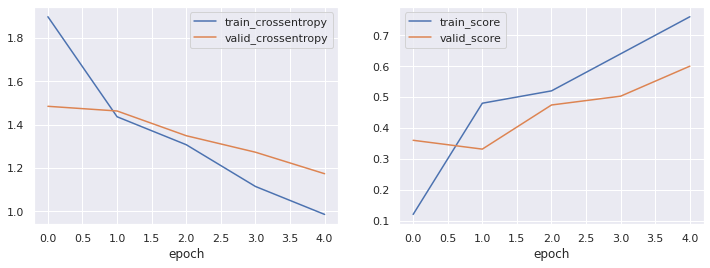

In [149]:
fig = plot_metricdf(metricdf, 0)
fig.savefig(joinpath(outputdir, f"metric_episode0.png"), bbox_inches='tight')

For omniprint, weight decay = 1, 100 epochs

In [120]:
"""
# max no droppout weight decay = 20
modelname = 'resnet18_sgd_weightdecay1_dropout0101_lr_1e-3'
resultname = resultprefix + '-' + modelname
print(resultname)

checkpoint_path = joinpath(modeldir, resultname + '-checkpoint.pth')

lossfunc = nn.CrossEntropyLoss(reduction='sum')
# lossfunc = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights.values).to(device), reduction='sum')

# model = get_model()
model = get_model_resnet_dropout(numberclass, with_dropout=True)
# model = get_model_resnet_dropblock(numberclass)
# best lr=1e-4

epochs = 20

optim = get_optimizer(model, lr=1e-3, weightdecay=1)
# optim = get_lrrange_optimizer(model, lrrange=(1e-6, 1e-3), get_optim_param_dict)
# optim = get_lrrange_optimizer(model, (1e-6, 1e-3), get_optim_param_dict_resnet, weightdecay=10)

lr_scheduler = get_epoch_lr_scheduler(optim, epochs)
# lr_scheduler = get_batch_lr_scheduler(optim, train_dataloader, epochs)
"""

"\n# max no droppout weight decay = 20\nmodelname = 'resnet18_sgd_weightdecay1_dropout0101_lr_1e-3'\nresultname = resultprefix + '-' + modelname\nprint(resultname)\n\ncheckpoint_path = joinpath(modeldir, resultname + '-checkpoint.pth')\n\nlossfunc = nn.CrossEntropyLoss(reduction='sum')\n# lossfunc = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights.values).to(device), reduction='sum')\n\n# model = get_model()\nmodel = get_model_resnet_dropout(numberclass, with_dropout=True)\n# model = get_model_resnet_dropblock(numberclass)\n# best lr=1e-4\n\nepochs = 20\n\noptim = get_optimizer(model, lr=1e-3, weightdecay=1)\n# optim = get_lrrange_optimizer(model, lrrange=(1e-6, 1e-3), get_optim_param_dict)\n# optim = get_lrrange_optimizer(model, (1e-6, 1e-3), get_optim_param_dict_resnet, weightdecay=10)\n\nlr_scheduler = get_epoch_lr_scheduler(optim, epochs)\n# lr_scheduler = get_batch_lr_scheduler(optim, train_dataloader, epochs)\n"

In [121]:
# result0, metric0 = train(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, optim, lossfunc, device, metricnames, 
#                          epochs=epochs, epoch_lr_scheduler=lr_scheduler, batch_lr_scheduler=None)

# save_checkpoint(result0['model'], optim, metric0['train_loss'][-1], checkpoint_path, epochs)
# save_result(metric0, joinpath(metricdir, resultname + ".json"))

# # save_model(result0['model'], joinpath(basedir, "model", f"{dataname}-{modelname}-imagesize_{imagesize[0]}x{imagesize[1]}.pth"))

In [122]:
def get_old_result_metric(model, old_result_path):
    with open(old_result_path) as resultjson:
        metric0 = json.load(resultjson)
    best_index = np.argmax(metric0['valid_score'])
    
    result0 = build_result(model, metric0['valid_score'][best_index], metric0['valid_loss'][best_index], best_index+1)
    return result0, metric0
        

In [123]:
# lossfunc = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights.values).to(device), reduction='sum')
# model = get_model()
# optim = get_optimizer(model, lr=1e-4)
# epochs=10

# model, optimizer, epoch, loss = load_checkpoint(checkpoint_path, model, optim)

# result1, metric1 = train(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, optim, lossfunc, device, metricnames, 
#                          epochs=epochs, epoch_lr_scheduler=None, batch_lr_scheduler=None)


In [124]:
def merge_result(result0, metric0, result1, metric1):
    merged_metric = {metricname0: metricvalue0 + metricvalue1 
                     for (metricname0, metricvalue0), (metricname1, metricvalue1) 
                     in zip(metric0.items(), metric1.items())}
    merged_result = result0 if result0['score'] > result1['score'] else result1
    
    return merged_result, merged_metric


In [125]:
# final_result, final_metric = result0, metric0

# result0, metric0 = get_old_result_metric(model, joinpath(metricdir, resultname + '.json'))
# final_result, final_metric = merge_result(result0, metric0, result1, metric1)
# save_checkpoint(final_result['model'], optim, final_metric['train_loss'][-1], checkpoint_path, epoch=40)
# save_result(final_metric, joinpath(metricdir, resultname + ".json"))

## Analyze train metric

In [127]:
# fig = plot_train_metric(metric0, resultname)
# sns.set_style("whitegrid")

# fig = plot_train_metric(final_metric, resultname)
# fig.savefig(joinpath(figdir, f"{resultname}.png"), bbox_inches='tight')


## Load result

In [128]:
# imagesize=(128, 128)
# modelname = 'resnet18'
# resultname = get_result_name()

# checkpoint_path = joinpath(modeldir, resultname + '-checkpoint.pth')
# # model = get_model()
# model = get_model_resnet(numberclass)
# optim = get_optimizer(model, lr=1e-4)
# model, optimizer, epoch, loss = load_checkpoint(checkpoint_path, model, optim)
# model.eval();
# # result1, metric1 = train(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, optim, lossfunc, device, metricnames, 
# #                          epochs=epochs, epoch_lr_scheduler=None, batch_lr_scheduler=None)


In [129]:
# def load_plot_metric(metricpath, resultname):
#     with open(metricpath) as resultjson:
#         metric = json.load(resultjson)
# #         metric['train_score'] = metric1['train_accuracy']
# #         metric['valid_score'] = metric1['valid_accuracy']

#     fig = plot_train_metric(metric, resultname)
    
#     return metric, fig
    
# # sns.set_theme()
# metric0, fig = load_plot_metric(joinpath(metricdir, resultname + '.json'), resultname)
# # fig.suptitle('sd128_v1_crop-mobilenetv2-imagesize128')
# fig.savefig(joinpath(figdir, resultname + "-balanced_accuracy.png"))


## All metrics

In [130]:
def predict_batch(model, inputs):
    outputs = model(inputs)
#     _, predictions = torch.argmax(outputs, dim=1)
    return outputs

def get_prediction_target(model, dataloader):
    targets = []
    outputs = []
    with torch.no_grad():
        model.eval()
        for inpt, target in dataloader:
            outputs.append(predict_batch(model, inpt.to(device)))
            targets.append(target)
    outputs = torch.cat(outputs).cpu()
    targets = torch.cat(targets).cpu()
    
    return outputs, targets

In [131]:
# %%time
# valid_outputs, valid_targets = get_prediction_target(final_result['model'].eval(), valid_dataloader)

# valid_outputs, valid_targets = get_prediction_target(model.eval(), valid_dataloader)
# valid_predictions = torch.argmax(valid_outputs, dim=1)
# print(f"{valid_outputs.shape = } ; {valid_targets.shape = } ; {valid_predictions.shape = }")

In [132]:
def report_metric(targets, predictions, labelnames):
    metric_report = pd.DataFrame(sklearn.metrics.classification_report(
        targets, predictions, output_dict=True, target_names=labelnames))
    return metric_report.T

# metric_report = report_metric(valid_targets, valid_predictions, labelnames)
# metric_report

In [133]:
def score_per_class(outputs, targets, predictions, labelcode):
    numclass = targets.max() + 1
#     scores = dict(auroc=[], auprc=[])
    metrics = 'auroc auprc matthews_corr cohen_kappa'.split(' ')
    scores = {metric: [] for metric in metrics}
    
    for labelindex in range(numclass):
        binary_targets = (targets == labelindex)
        binary_predictions = (predictions == labelindex)
        selected_outputs = outputs[:,labelindex]
        
        scores['auroc'].append(sklearn.metrics.roc_auc_score(binary_targets, selected_outputs))
        scores['auprc'].append(sklearn.metrics.average_precision_score(binary_targets, selected_outputs))
        scores['matthews_corr'].append(sklearn.metrics.matthews_corrcoef(binary_targets, binary_predictions))
        scores['cohen_kappa'].append(sklearn.metrics.cohen_kappa_score(binary_targets, binary_predictions))
#         scores['balanced_accuracy'] = sklearn.metrics.balanced_accuracy_score(targets, predictions)
                                                    
    scores = pd.DataFrame(scores, index=labelcode.inverse_transform(range(numberclass)))
    return scores

# scores = score_per_class(F.softmax(valid_outputs, dim=1), valid_targets, valid_predictions, labelcode)
# scores

In [134]:
def merge_metric(report, scores):
    merged = pd.merge(report, scores, how='left' ,left_index=True, right_index=True)
    return merged

# all_metrics = merge_metric(metric_report, scores)
# all_metrics.to_csv(joinpath(metricdir, resultname + '-all_metric.csv'))
# all_metrics

## Load metric

In [135]:
# imagesize=(128, 128)
# modelname = 'mobilenetv2'
# resultname = get_result_name()

# all_metrics = pd.read_csv(joinpath(metricdir, resultname + '-all_metric.csv'), index_col=0)
# # all_metrics = pd.read_csv(joinpath(basedir, 'result/sd128_v1_crop/sd128_v1_crop-mobilenetv2-imagesize_128x128-balanced_accuracy-all_metric.csv'), index_col=0)
# all_metrics

## Easiest and hardest labels

## Plot AUROC

## Compare metrics and confusion matrix

In [136]:
def get_confusion_matrix(targets, predictions, labelcode):
    confusion = sklearn.metrics.confusion_matrix(targets, predictions)
    labelnames = labelcode.inverse_transform(range(targets.max().item() + 1))

    confusion = pd.DataFrame(confusion, columns=labelnames, index=labelnames)
    confusion.index.name = 'Actual'
    confusion.columns.name = 'Predicted'
    
    return confusion

# confusion = get_confusion_matrix(valid_targets.detach().cpu(), valid_predictions.detach().cpu(), labelcode)

In [137]:
def plot_heatmap_4crop(weightmatrix, figsize=(20, 20), title=None):
    mid = len(weightmatrix) // 2
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
#     axes[0].plot(sns.heatmap(weightmatrix.iloc[:mid, :mid], cmap="Reds"))
    sns.heatmap(weightmatrix.iloc[:mid, :mid], cmap="Reds", ax=axes[0], square=True, annot=True)
    sns.heatmap(weightmatrix.iloc[:mid, mid:], cmap="Reds", ax=axes[1], square=True, annot=True)
    sns.heatmap(weightmatrix.iloc[mid:, :mid], cmap="Reds", ax=axes[2], square=True, annot=True)
    sns.heatmap(weightmatrix.iloc[mid:, mid:], cmap="Reds", ax=axes[3], square=True, annot=True)
    plt.tight_layout()
    
    if title: plt.suptitle(title)
    
    return fig

# fig = plot_heatmap_4crop(confusion, title=f"{resultname}-confusion-4crop")
# fig.savefig(joinpath(figdir, f"{resultname}-confusion.png"), bbox_inches='tight')

## GradCAM

In [138]:
def get_attribution_layer(model):
#     layer = list(model.base.features.children())[-1]
    layer = model.layer4[1].conv2
    return layer

# trained_model = final_result['model']
# # trained_model = model
# layer_gradcam = captum.attr.LayerGradCam(trained_model, get_attribution_layer(trained_model))

In [139]:
def sample_inference(model, dataset, device, samplesize=1):
    sampleindex = np.random.randint(0, len(dataset), samplesize)
    inpts =[]; labels = []
    
    for index in sampleindex:
        inpt, label = dataset[index]
        inpts.append(inpt)
        labels.append(label)
    
    inpts = torch.stack(inpts).to(device)
    labels = torch.tensor(labels).to(device)
    
    predictions = predict_batch(model, inpts)
    
    return inpts, labels, predictions
    

In [140]:
def plot_gradcam(layer_gradcam, inpt, label, prediction, labelcode, title=None):
    gradcam_attr = layer_gradcam.attribute(inpt.unsqueeze(0).to(device), label, relu_attributions=False)

    # upsample CAM to original image size
    gradcam_upsample = scipy.ndimage.interpolation.zoom(
      gradcam_attr.squeeze(0).cpu().detach().numpy(), 
      np.array(inpt.shape)/np.array(gradcam_attr.shape[1:]),
    )
#     gradcam_upsample = captum.attr.LayerAttribution.interpolate(
#         gradcam_attr.cpu().detach(), inpt.shape[-2:]).squeeze(0)
#     print(gradcam_upsample.shape)

    fig, ax = captum.attr.visualization.visualize_image_attr_multiple(
        np.transpose(gradcam_upsample, (1,2,0)), 
        tensor_to_display(inpt.cpu().detach()),
        methods = 'original_image blended_heat_map'.split(' '),
        signs='absolute_value absolute_value'.split(' '),
        alpha_overlay=0.6,
        cmap='viridis',
        titles=[f'truth: {labelcode.inverse_transform([label.item()])[0]}', 
                f'prediction: {labelcode.inverse_transform([prediction.item()])[0]}'],
        show_colorbar=True,
    )
    
    if title: fig.suptitle(title)
        
    return fig

In [141]:
# sample_inputs, sample_labels, sample_predictions = sample_inference(trained_model, valid_dataset, device)
# fig = plot_gradcam(layer_gradcam, sample_inputs[0], sample_labels[0], sample_predictions[0], labelcode, title=resultname+'gradcam')

# selected_label = class_metrics['matthews_corr'].sort_values().index[7]
# # select_mask = ((valid_predictions == valid_targets) & (valid_targets == labelcode.transform([selected_label])[0]))
# select_mask =  (valid_targets == labelcode.transform([selected_label])[0])
# selected_index = np.where(select_mask == 1)[0]
# sample_index = np.random.choice(selected_index)

# sample_index = np.random.randint(0, len(valid_predictions), 1)[0]
# fig = plot_gradcam(layer_gradcam, valid_dataset[sample_index][0], valid_targets[sample_index], valid_predictions[sample_index], 
#                    labelcode, title=resultname + '-gradcam')
# fig.savefig(joinpath(figdir, f"{resultname}-gradcam.png"), bbox_inches='tight')